In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import utils as ut

General input

In [2]:
option = 'detrend_mix_biasadj_'

year0,year1 = 1951,2100
#year0,year1 = 1851,2000

Indicate which runs are ready

In [3]:
ready = {}
ready['eais'] = False
ready['ross'] = False
ready['amun'] = False
ready['wedd'] = False
ready['pens'] = False
ready['totl'] = False #When True, can remove dummy ORF code below
ready['half'] = False
ready['doub'] = False

#When all true, can remove TOTL-based ORFs and 'ready'-dependence

Read some other input data - do not change

In [4]:
nyears = year1-year0+1
rftime = np.arange(nyears)
basin = ut.basin
ssp = ut.ssp
exp = ut.exp

Define ice sheet model names, different names for IRF and SRF data

In [5]:
ism   = ['CISM_NCA','FETI_ULB','GRIS_LSC','IMAU_UU','ISSM_UCI','MALI_DOE','PISM_DMI','PISM_PIK','SICO_ILTS']


ism_i = ['CISM_NCA','FETISH_ULB','GRIS_LSC','IMAU_VUB','ISSM_UCI','MALI_DOE','PISM_DMI','PISM_PIK','SICO_ILTS']
ism_s = ['CISM_NCA','FETI_VUB','GRIS_LSC','IMAU_VUB','ISSM_UCI','MALI_LAN','PISM_DMI','PISM_PIK','SICO_UHO']
region = ['R1','R2','R3','R4','R5']

Read IRFs and SRFs

In [6]:
#Read IRF
irf  = np.zeros((len(rftime),len(ism),len(basin)))
for i,ii in enumerate(ism_i):
    for r,reg in enumerate(region):
        with open(f'../data/Larmip/RFunctions_total/RF_{ii}_BM08_{reg}.dat') as f:
            irf[:,i,r] = np.array([float(x) for x in f.readlines()])[:nyears]

#Read SRF
srf  = np.zeros((len(rftime),len(ism),len(basin)))
for i,ii in enumerate(ism_s):
    for r,reg in enumerate(region):
        with open(f'../data/Larmip/RFunctions/RF_{ii}_BM08_{reg}.dat') as f:
            srf[:,i,r] = np.array([float(x) for x in f.readlines()])[:nyears]

Get metadata for CMIP6 temperature files from Eveline

In [7]:
#Get available ESMs for CMIP6 temperature data
mods = {}
for s,ss in enumerate(ssp):
    ds2 = xr.open_dataset(f'../data/eveline/thetao_{option}sector_timeseries_historical+ssp{ss}_1850_2100.nc')
    mods[ss] = ds2.model.values
allmods = set(mods[ssp[0]]) & set(mods[ssp[1]]) & set(mods[ssp[2]])
esm = sorted(np.array([mod for mod in allmods]))
print(len(esm),esm)

#Get coordinates from Eveline's file
ds2 = xr.open_dataset(f'../data/eveline/thetao_{option}sector_timeseries_historical+ssp{ssp[0]}_1850_2100.nc')
ds2 = ds2.sel(year=slice(year0,year1))
evbas = ['eais','ross','amun','wedd','apen']

time = ds2.year.values
ds2.close()

14 ['ACCESS-CM2', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CMCC-ESM2', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MIROC6', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-MM']


Read temperature time series

In [9]:
#Read temperature

temp = np.zeros((len(time),len(esm),len(ssp),len(basin)))
for s,ss in enumerate(ssp):
    ds2 = xr.open_dataset(f'../data/eveline/thetao_{option}sector_timeseries_historical+ssp{ss}_1850_2100.nc')
    ds2 = ds2.sel(year=slice(year0,year1))
    for e,es in enumerate(esm):
        for b,eb in enumerate(evbas):
            temp[:,e,s,b] = ds2[eb].sel(model=es).values
        #print(ss,es,temp[-1,e,s,:])
    ds2.close()

Create dummy ORFs 

*Remove when TOTL run is ready*

In [10]:
orf  = np.zeros((len(rftime),len(exp),len(basin)))

#Magnitude and time scale of response 

pert = 400 #Gt/yr

mag = [.4,.2,.4,.2,.4] #degC
tsc = [50,25,15,20,10] #year

for b,bas in enumerate(basin):
    orf[:,b,b] = mag[b]*(1-np.exp(-rftime/tsc[b]))/pert

for b,bas in enumerate(basin):
    orf[:,5,b] = orf[:,b,b]

orf[:,6,:] = .5* orf[:,5,:]
orf[:,7,:] =  2* orf[:,5,:]

Overwrite all ORFs with response to TOTL perturbation, assuming perfect independence and linearity

*Remove when all runs are ready*

In [11]:
ds = xr.open_dataset(f'../data/temperature_ctrl.nc')
tctrl = ds.temp
ds.close()

pert = 400

if ready['totl']:
    orf  = np.zeros((len(rftime),len(exp),len(basin)))
    
    ds = xr.open_dataset(f'../data/temperature_totl.nc')
    dtemp = ds.temp - tctrl
    ds.close()

    #Individual basin responses
    for b,bas in enumerate(basin):
        orf[:,b,b] = dtemp.sel(basin=bas)

    #TOTL
    orf[:,5,:] = dtemp

    #HALF and DOUB
    orf[:,6,:] = .5* orf[:,5,:]
    orf[:,7,:] =  2* orf[:,5,:]

Overwrite real ORFs if runs are ready

In [12]:
for e,ee in enumerate(exp):
    if ready[ee]:
        ds = xr.open_dataset(f'../data/temperature_{ee}.nc')
        orf[:,e,:] = ds.temp - tctrl
        ds.close()

Save all data in one nc file

In [13]:
irf2  = xr.DataArray(irf,dims=('rftime','ism','basin'),coords={'rftime':rftime,'ism':ism,'basin':basin},attrs={'unit':'Gt/yr per m/yr','long_name':'ice mass loss response function to increased basal melt'})
srf2  = xr.DataArray(srf,dims=('rftime','ism','basin'),coords={'rftime':rftime,'ism':ism,'basin':basin},attrs={'unit':'m/yr per m/yr','long_name':'sea level response function to increased basal melt'})
temp2 = xr.DataArray(temp,dims=('time','esm','ssp','basin'),coords={'time':time,'esm':esm,'ssp':ssp,'basin':basin},attrs={'unit':'degrees Celcius','long_name':'temperature anomaly from pre-industrial control'})
orf2  = xr.DataArray(orf,dims=('rftime','exp','basin'),coords={'rftime':rftime,'exp':exp,'basin':basin},attrs={'unit':'degrees Celcius per Gt/yr','long_name':'ocean response function to increased mass loss'})

ds = xr.Dataset({'irf':irf2,'srf':srf2,'temp':temp2,'orf':orf2})
ds.to_netcdf(f'../data/alldata_{year0}_{year1}.nc',mode='w')
ds

<xarray.Dataset>
Dimensions:  (rftime: 150, ism: 9, basin: 5, time: 150, esm: 14, ssp: 3, exp: 8)
Coordinates:
  * rftime   (rftime) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
  * ism      (ism) <U9 'CISM_NCA' 'FETI_ULB' ... 'PISM_PIK' 'SICO_ILTS'
  * basin    (basin) <U9 'East Ant.' 'Ross' 'Amundsen' 'Weddell' 'Peninsula'
  * time     (time) int64 1951 1952 1953 1954 1955 ... 2096 2097 2098 2099 2100
  * esm      (esm) <U13 'ACCESS-CM2' 'CAMS-CSM1-0' ... 'MRI-ESM2-0' 'NorESM2-MM'
  * ssp      (ssp) <U3 '126' '245' '585'
  * exp      (exp) <U4 'eais' 'ross' 'amun' 'wedd' 'pens' 'totl' 'half' 'doub'
Data variables:
    irf      (rftime, ism, basin) float64 188.6 353.5 60.47 ... 355.1 9.138
    srf      (rftime, ism, basin) float64 8.399e-06 1.527e-06 ... 2.146e-05
    temp     (time, esm, ssp, basin) float64 0.3459 -0.1952 ... 0.3548 1.11
    orf      (rftime, exp, basin) float64 0.0 0.0 0.0 ... 0.002 0.0009994 0.002

Make some plots

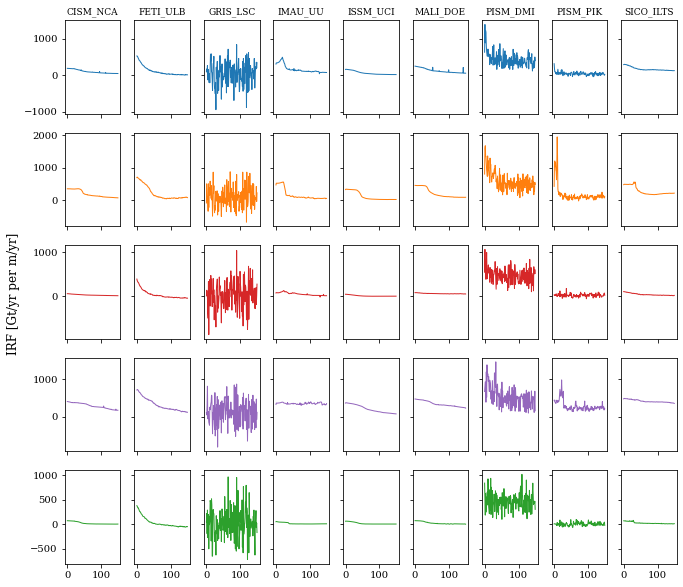

In [14]:
fig,ax = plt.subplots(len(basin),len(ism),sharex=True,sharey='row',figsize=(10,10))

for i,im in enumerate(ism):
    ax[0,i].set_title(im)
    for b,bas in enumerate(basin):
        ax[b,i].plot(rftime,irf[:,i,b],c=ut.bcol[bas],label=bas)

fig.supylabel('IRF [Gt/yr per m/yr]')
plt.show()

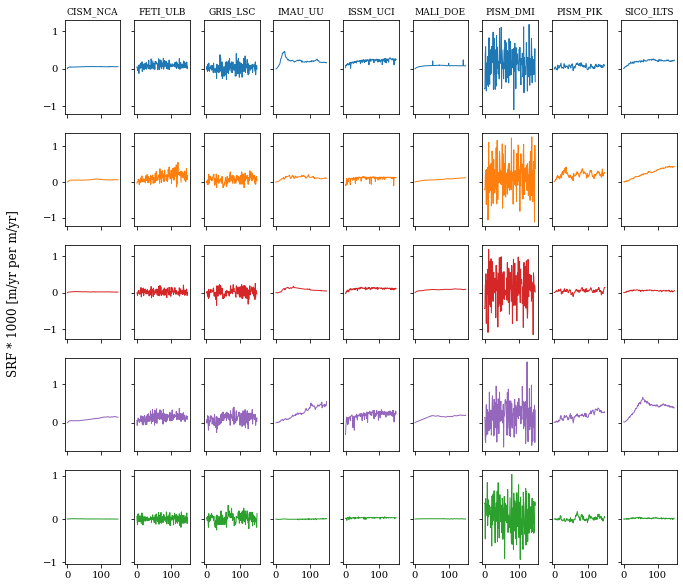

In [15]:
fig,ax = plt.subplots(len(basin),len(ism),sharex=True,sharey='row',figsize=(10,10))

for i,im in enumerate(ism):
    ax[0,i].set_title(im)
    for b,bas in enumerate(basin):
        ax[b,i].plot(rftime,1000*srf[:,i,b],c=ut.bcol[bas],label=bas)

fig.supylabel('SRF * 1000 [m/yr per m/yr]')
plt.show()


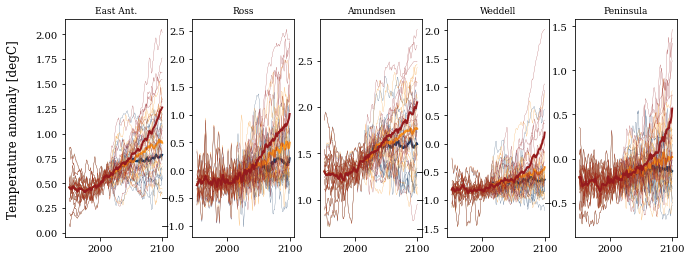

In [17]:
fig,ax = plt.subplots(1,len(basin),sharex=True,figsize=(10,4))

for b,bas in enumerate(basin):
    ax[b].set_title(bas)

    for s,ss in enumerate(ssp):
        ax[b].plot(time,np.mean(ds.temp[:,:,s,b],axis=1),c=ut.scol[ss],lw=2)
        for e,es in enumerate(esm):
            ax[b].plot(time,ds.temp[:,e,s,b],c=ut.scol[ss],lw=.2)
            
fig.supylabel('Temperature anomaly [degC]')
plt.show()

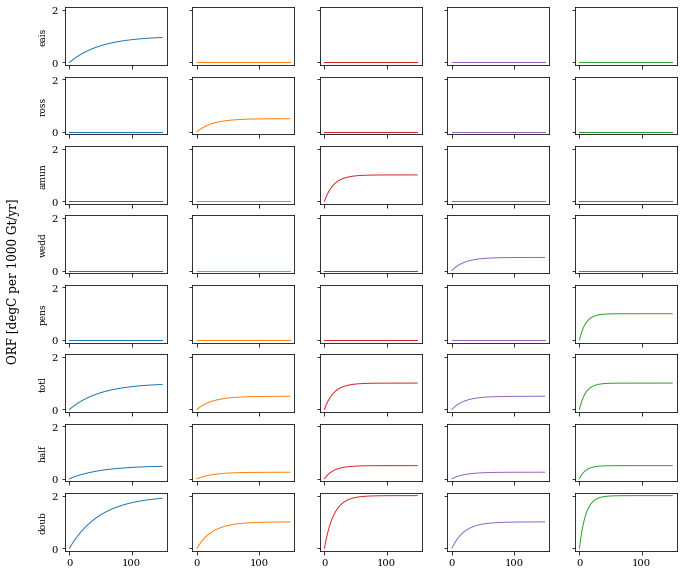

In [23]:
fig,ax = plt.subplots(len(exp),len(basin),sharex=True,sharey=True,figsize=(10,10))

for e,ee in enumerate(exp):
    for b,bas in enumerate(basin):
        ax[e,b].plot(rftime,1000*orf[:,e,b],c=ut.bcol[bas])
    ax[e,0].set_ylabel(ee)

fig.supylabel('ORF [degC per 1000 Gt/yr]')
plt.show()